In [71]:
import pandas as pd 
import pandas_datareader.data as web
import datetime
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [36]:
start = datetime.datetime(2020,1,1)
end = datetime.datetime(2021,1,1)

In [37]:
crypto_tickers = ['BTC-USD', 'BCH-USD', 'ETH-USD', 'LTC-USD', 
                 'BNB-USD', 'TRX-USD', 'LINK-USD', 'DOGE-USD',
                 'DOT1-USD']

In [38]:
# crypto_dict = {}
# for ticker in crypto_tickers:
#     data = web.DataReader(ticker, 'yahoo', start, end)
#     crypto_dict[ticker] = data['Close'].values
# crypto = pd.DataFrame(crypto_dict)

In [39]:
btc = web.DataReader('BTC-USD', 'yahoo', start, end)
bch = web.DataReader('BCH-USD', 'yahoo', start, end)
eth = web.DataReader('ETH-USD', 'yahoo', start, end)
ltc = web.DataReader('LTC-USD', 'yahoo', start, end)
bnb = web.DataReader('BNB-USD', 'yahoo', start, end)
trx = web.DataReader('TRX-USD', 'yahoo', start, end)
link = web.DataReader('LINK-USD', 'yahoo', start, end)
doge = web.DataReader('DOGE-USD', 'yahoo', start, end)
polkadot = web.DataReader('DOT1-USD', 'yahoo', start, end)

In [42]:
crypto = pd.concat([btc['Close'], eth['Close'], bch['Close'],
                   ltc['Close']], axis=1)
crypto.columns = ['Bitcoin', 'Ethereum','Bitcoin Cash', 'Litecoin']

In [43]:
crypto.head()

,Bitcoin,Ethereum,Bitcoin Cash,Litecoin
Date,,,,
2020-01-01,7200.174316,130.802002,204.397537,42.017719
2020-01-02,6985.470215,127.410179,195.698563,39.823013
2020-01-03,7344.884277,134.171707,222.412979,42.415573
2020-01-04,7410.656738,135.069366,226.018692,43.326607
2020-01-05,7411.317383,136.276779,224.096527,43.553207


In [44]:
returns = crypto/crypto.shift(1)

In [45]:
returns.head()

,Bitcoin,Ethereum,Bitcoin Cash,Litecoin
Date,,,,
2020-01-01,NaN,NaN,NaN,NaN
2020-01-02,0.970181,0.974069,0.957441,0.947767
2020-01-03,1.051452,1.053069,1.136508,1.065102
2020-01-04,1.008955,1.006690,1.016212,1.021479
2020-01-05,1.000089,1.008939,0.991496,1.005230


In [47]:
log_returns = np.log(returns)
log_returns.head()

,Bitcoin,Ethereum,Bitcoin Cash,Litecoin
Date,,,,
2020-01-01,NaN,NaN,NaN,NaN
2020-01-02,-0.030273,-0.026273,-0.043491,-0.053646
2020-01-03,0.050172,0.051709,0.127960,0.063071
2020-01-04,0.008915,0.006668,0.016082,0.021251
2020-01-05,0.000089,0.008899,-0.008541,0.005216


In [ ]:
#sharpe ratio


In [61]:
n_portfolios = 10000

weights = np.zeros((n_portfolios,4))
expected_return = np.zeros(n_portfolios)
expected_volatility = np.zeros(n_portfolios)
sharpe_ratio = np.zeros(n_portfolios)

mean_log_return = log_returns.mean()
sigma = log_returns.cov()

for k in range(n_portfolios):
    w = np.array(np.random.random(4))
    w = w/np.sum(w)
    weights[k,:] = w
    # expected log returns
    expected_return[k] = np.sum(mean_log_return * w)
    # expected volatility
    expected_volatility[k] = np.sqrt(np.dot(w.T, np.dot(sigma,w)))
    #sharpe ratio
    sharpe_ratio[k] = expected_return[k]/expected_volatility[k] 
    

In [62]:
max_index = sharpe_ratio.argmax()
weights[max_index, :]

array([0.91689648, 0.04497938, 0.00343763, 0.03468651])

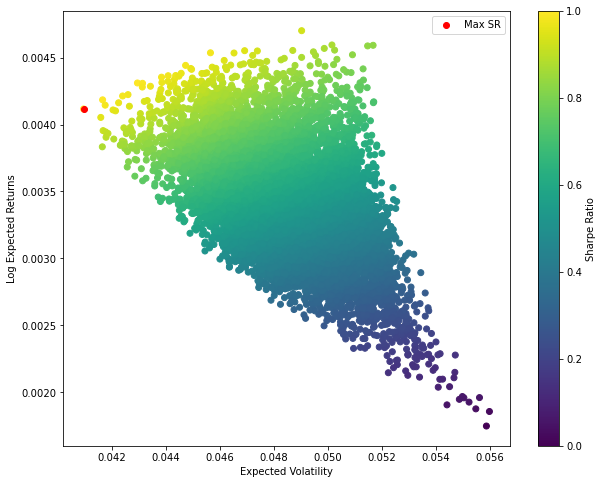

In [70]:
plt.figure(figsize=(10,8))
plt.scatter(expected_volatility, expected_return, c=sharpe_ratio)
plt.scatter(expected_volatility[max_index], 
            expected_return[max_index], c='red', label='Max SR')
plt.xlabel('Expected Volatility')
plt.ylabel('Log Expected Returns')
plt.colorbar(label='Sharpe Ratio')
plt.legend()

In [78]:
def negative_sharpe(w):
    w = np.array(w)
    r = np.sum(mean_log_return * w) 
    v = np.sqrt(np.dot(w.T, np.dot(sigma,w)))
    sr = r/v
    return -1*sr

def check_sum_to_one(w):
    return np.sum(w) - 1


In [79]:
w0 = [.25, .25, .25, .25]
bounds = ((0,1),(0,1),(0,1),(0,1))
constraints = ({'type':'eq', 'fun': check_sum_to_one})
w_opt = minimize(negative_sharpe, w0, method ='SLSQP', bounds=bounds,
                constraints=constraints)

In [81]:
w_opt.x

array([8.43228513e-01, 1.56771487e-01, 0.00000000e+00, 3.28296418e-16])

In [91]:
returns = np.linspace(0,.0045,100)
volatility_opt = []
def minimize_volatility(w):
    w = np.array(w)
    v = np.sqrt(np.dot(w.T, np.dot(sigma,w)))
    return v

def get_return(w):
    w = np.array(w)
    r = np.sum(mean_log_return*w)
    return r

for r in returns:
    constraints = ({'type':'eq','fun': check_sum_to_one},
                  {'type':'eq','fun':lambda w: get_return(w) - r})
    opt = minimize(minimize_volatility, w0, 
                    method ='SLSQP', bounds=bounds,
                constraints=constraints)
    volatility_opt.append(opt['fun'])
    

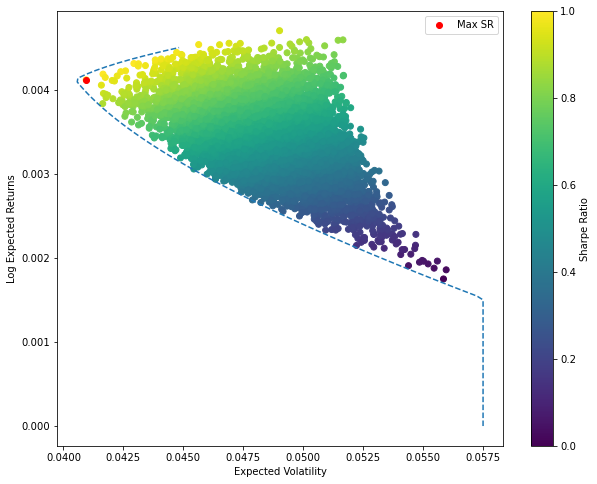

In [94]:
plt.figure(figsize=(10,8))
plt.scatter(expected_volatility, expected_return, c=sharpe_ratio)
plt.scatter(expected_volatility[max_index], 
            expected_return[max_index], c='red', label='Max SR')
plt.xlabel('Expected Volatility')
plt.ylabel('Log Expected Returns')
plt.colorbar(label='Sharpe Ratio')
plt.plot(volatility_opt, returns,'--')
plt.legend()